## Neural Machine Translation 
Sequence to Sequence (seq2seq)

## 1. Introduction to Sequence-to-Sequence (Seq2Seq) Modeling

Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks.

Our aim is to translate given sentences from one language to another.
- In other words, these sentences are a sequence of words going in and out of a model. 
- This is the basic idea of Sequence-to-Sequence modeling.

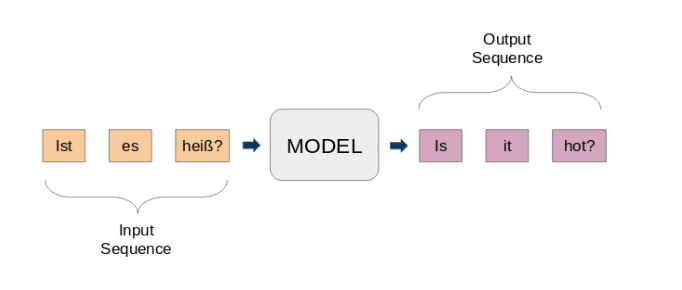

Both these parts are essentially two different recurrent neural network (RNN) models combined into one giant network:

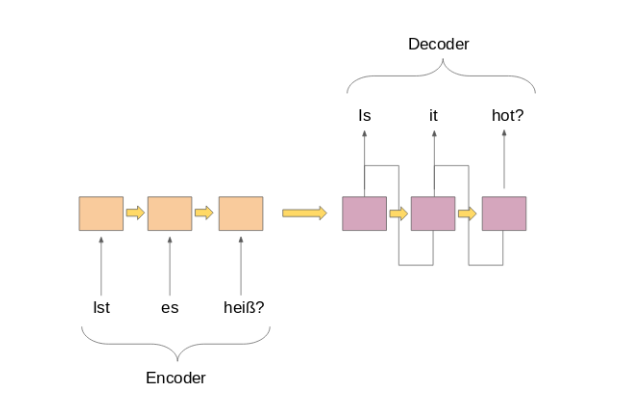

## 2. Import Required Libraries

In [1]:
import numpy as np
import string
import re
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

### 3. Read Data

Our data is a text file of English-Korean sentence pairs. 
First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-Korean pairs separated by '\n' and then split these pairs into English sentences and Korean sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("kor.txt")
kor_eng = to_lines(data)
kor_eng = np.array(kor_eng)
print(len(kor_eng))
kor_eng.shape

3729


(3729, 3)

### 4. Text Pre-Processing

#### (a) Text Cleaning
 - Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [6]:
kor_eng

array([['Go.', '가.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)'],
       ['Hi.', '안녕.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)'],
       ['Run!', '뛰어!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)'],
       ...,
       ["I think it's a shame that some foreign language teachers were able to graduate from college without ever having studied with a native speaker.",
        '몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었다는 건 창피한 일인 것 같아.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953635 (CK) & #8384140 (Eunhee)'],
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        '만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어민

We will get rid of the punctuation marks, and then convert the text to lower case.

In [7]:
# Remove punctuation
kor_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in kor_eng[:,0]]
kor_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in kor_eng[:,1]]

In [8]:
kor_eng

array([['Go', '가',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)'],
       ['Hi', '안녕',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)'],
       ['Run', '뛰어',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)'],
       ...,
       ['I think its a shame that some foreign language teachers were able to graduate from college without ever having studied with a native speaker',
        '몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었다는 건 창피한 일인 것 같아',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953635 (CK) & #8384140 (Eunhee)'],
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        '만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어민이 아니라고 깨닫게 해주는 뭔

In [9]:
# convert to lowercase
for i in range(len(kor_eng)):
    kor_eng[i,0] = kor_eng[i,0].lower()    
    kor_eng[i,1] = kor_eng[i,1].lower()

In [10]:
kor_eng

array([['go', '가',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8363271 (Eunhee)'],
       ['hi', '안녕',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee)'],
       ['run', '뛰어',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8355891 (Eunhee)'],
       ...,
       ['i think its a shame that some foreign language teachers were able to graduate from college without ever having studied with a native speaker',
        '몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었다는 건 창피한 일인 것 같아',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953635 (CK) & #8384140 (Eunhee)'],
       ['if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker',
        '만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어민이 아니라고 깨닫게 해주는 뭔

#### (b) Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [11]:
# empty lists
eng_l = []
kor_l = []

# populate the lists with sentence lengths
for i in kor_eng[:,0]:
    eng_l.append(len(i.split()))

for i in kor_eng[:,1]:
    kor_l.append(len(i.split()))


In [12]:
df = pd.DataFrame({'eng':eng_l, 'kor':kor_l})

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3729 entries, 0 to 3728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   eng     3729 non-null   int64
 1   kor     3729 non-null   int64
dtypes: int64(2)
memory usage: 58.4 KB


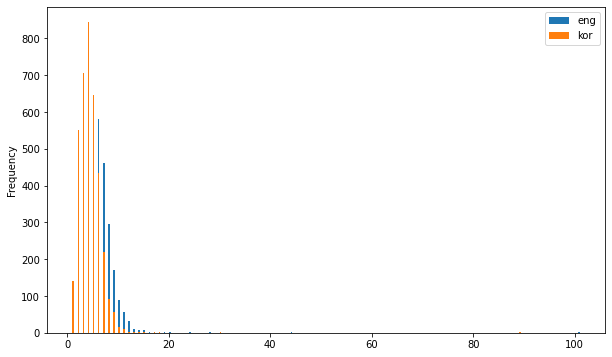

In [14]:
df.plot.hist(bins = 300,figsize=(10, 6))
plt.show()

#### The maximum length of the Korean sentences is 15 and that of the English phrases is 20.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(kor_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 20

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2561


In [17]:
# prepare Korean tokenizer
kor_tokenizer = tokenization(kor_eng[:, 1])
kor_vocab_size = len(kor_tokenizer.word_index) + 1

kor_length = 20
print('Korean Vocabulary Size: %d' % kor_vocab_size)

Korean Vocabulary Size: 5656


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### 5.  Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(kor_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [20]:
# prepare training data
trainX = encode_sequences(kor_tokenizer, kor_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [21]:
# prepare validation data
testX = encode_sequences(kor_tokenizer, kor_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [22]:
trainX.shape, trainY.shape

((2983, 20), (2983, 20))

In [23]:
testX.shape, testY.shape

((746, 20), (746, 20))

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

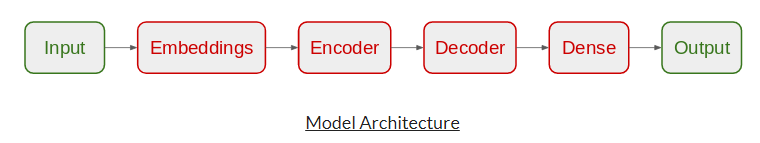

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [25]:
model = build_model(kor_vocab_size, eng_vocab_size, kor_length, eng_length, 64)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['acc'])

loss='sparse_categorical_crossentropy': because it allows us to use the target sequence as it is instead of one hot encoded format.
- One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

- We will train it for 30 epochs and with a batch size of 64. 

In [26]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=64, 
          validation_split = 0.2,   verbose=1)

Epoch 1/10
38/38 [==============================] - 10s 61ms/step - loss: 4.7328 - acc: 0.7074 - val_loss: 2.5778 - val_acc: 0.7293
Epoch 2/10
38/38 [==============================] - 1s 22ms/step - loss: 2.3301 - acc: 0.7269 - val_loss: 2.2301 - val_acc: 0.7293
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 2.1592 - acc: 0.7269 - val_loss: 2.0989 - val_acc: 0.7293
Epoch 4/10
38/38 [==============================] - 1s 21ms/step - loss: 1.9850 - acc: 0.7269 - val_loss: 2.0010 - val_acc: 0.7293
Epoch 5/10
38/38 [==============================] - 1s 21ms/step - loss: 1.8921 - acc: 0.7269 - val_loss: 1.9330 - val_acc: 0.7293
Epoch 6/10
38/38 [==============================] - 1s 21ms/step - loss: 1.8460 - acc: 0.7307 - val_loss: 1.8929 - val_acc: 0.7378
Epoch 7/10
38/38 [==============================] - 1s 21ms/step - loss: 1.8037 - acc: 0.7366 - val_loss: 1.9514 - val_acc: 0.7401
Epoch 8/10
38/38 [==============================] - 1s 21ms/step - loss: 1.7738 - 

Let's compare the training loss and the validation loss.

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

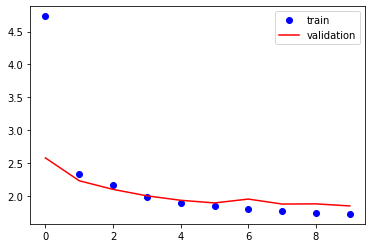

In [28]:
plt.plot(history.history['loss'],'bo')
plt.plot(history.history['val_loss'],'r')
plt.legend(['train','validation'])
plt.show()

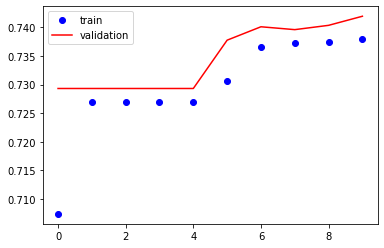

In [29]:
plt.plot(history.history['acc'],'bo')
plt.plot(history.history['val_acc'],'r')
plt.legend(['train','validation'])
plt.show()